In [1]:
import networkx as nx
from networkx.generators.random_graphs import _random_subset
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


import time

save_graph = False

## Creazione del grafo

In [2]:
N = 50

G = nx.complete_graph(N)
G.remove_edges_from([(2, 3), (4, 0), (5, 8), (7, 3)])

Rappresentazione del grafico

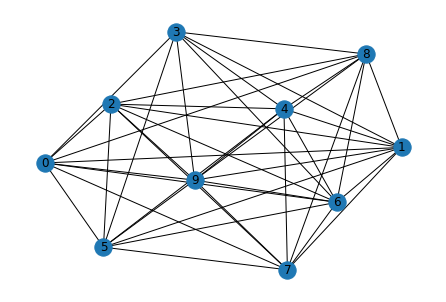

In [3]:
nx.draw(G, with_labels=True)    
plt.show()

if save_graph: 
    nx.write_adjlist(G, "CO.adjlist")

## Analisi del grafo

Estrazione della matrice di adiacenza A

In [4]:
adjacency = list(G.adjacency())
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)] 
    for c in b : 
        A[a][c] = 1

Estrazione della matrice di stocastica P e calcolo dei suoi autovalori e autovettori

In [5]:
P = []
for a, b in adjacency :
    P += [[0]*len(adjacency)]
    for c in b: 
        P[a][c] = 1./G.degree[a]

In [6]:
matrixP = np.array(P)
autovaloriP, autovettoriP = np.linalg.eig(np.transpose(matrixP))
autovettoriP = np.transpose(autovettoriP)

diff = [np.abs(autovaloriP[i] - 1) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriP[i] - 1) == minDiff:
        pS = autovettoriP[i]
        print("Eigenvector found")
        break

if pS[0] < 0:
    pS = -pS

Eigenvector found


In [7]:
autovaloriP

array([ 1.00000000e+00,  5.25181503e-02,  6.91925078e-17, -2.95462442e-01,
       -2.50000000e-01, -1.59833486e-01,  0.00000000e+00, -1.25000000e-01,
       -1.11111111e-01, -1.11111111e-01])

Definizione della matrice laplaciana L e calcolo dei suoi autovettori e autovalori

In [8]:
matrixL = np.identity(N) - matrixP

In [9]:
autovaloriL, autovettoriL = np.linalg.eig(np.transpose(matrixL))
autovettoriL = np.transpose(autovettoriL)

diff = [np.abs(autovaloriL[i]) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriL[i]) == minDiff:
        pS_L = autovettoriL[i]
        FiedlerEigenvalues = list(autovaloriL)
        FiedlerEigenvalues.remove(autovaloriL[i])
        print("Eigenvector found")
        break

if pS_L[0] < 0:
    pS_L = -pS_L

Eigenvector found


In [10]:
autovaloriL

array([0.        , 1.29546244, 1.25      , 1.15983349, 1.        ,
       0.94748185, 1.        , 1.125     , 1.11111111, 1.11111111])

La distribuzione stazionaria e il valore di Fiedler estratto dalle due matrici L e P coincidono fino alla 13-esima cifra decimale

In [11]:
i = 13
np.round(pS, i) == np.round(pS_L, i)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [12]:
np.round(1-max(autovaloriP[1:]), i) == np.round(min(autovaloriL[1:]), i)

True

Definizione del valore valore di Fiedler e della distribuzione stazionaria approssimate

In [13]:
FiedlerValue = round(min(FiedlerEigenvalues), i)
print(FiedlerValue)

0.9474818496507


In [14]:
pS = np.round(pS.real, i)
print(pS)

[0.30769231 0.34615385 0.30769231 0.26923077 0.30769231 0.30769231
 0.34615385 0.30769231 0.30769231 0.34615385]


In [15]:
if save_graph: 
    np.savetxt("CO-pS.txt", pS, delimiter='\n')

Assegnazione degli individui ai nodi per l'evoluzione della dinamica. L'assegnazione degli individui può essere fatta secondo una distribuzione uniforme oppure concentrando tutti gli indivisui in un punto.

## Dinamica sul grafo

In [16]:
walker_per_node = 1000

start_node = 2
walkers = int(1e3)

In [17]:
seed = np.random.RandomState()
def dynamic_evolution(G, history = []):
    evolution = [0] * len(G.nodes)
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neighbours = list(G[n])
            new_node = _random_subset(neighbours, 1, seed).pop()
            evolution[new_node] += 1
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[n]
    history += [evolution]

In [18]:
history = [[], [], []]
for h in range(len(history)):
#     history[h] = [[walker_per_node] * len(G.nodes)]
    history[h] = [[0] * len(G.nodes)]
    history[h][0][start_node] = walkers

In [19]:
time_steps = int(5e2)

In [20]:
t0 = time.time()

for h in range(len(history)):
    for n in G.nodes:
#         G.nodes[n]['N_i'] = walker_per_node
        G.nodes[n]['N_i'] = 0
    G.nodes[start_node]['N_i'] = walkers
    
    for t in range(time_steps):
        dynamic_evolution(G, history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 1 minutes and 35.12947058677673 seconds


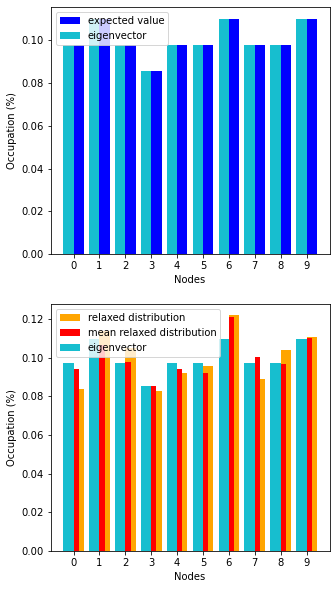

In [21]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(0.5*N, 10))

pSExpected = [d for n, d in G.degree()]
pSNorm = [h/sum(pS) for h in pS]

total_walkers = sum(history[0][0])

hMean = [[(h1+h2+h3)/total_walkers/3 
          for h1, h2, h3 in zip(history[0][i], history[1][i], history[2][i])] 
         for i in range(len(history[0]))]

ax[0].bar(G.nodes, [h/sum(pSExpected) for h in pSExpected], width=0.4, align='edge', color='blue', label="expected value")
ax[0].bar(G.nodes, [h for h in pSNorm], width=-0.4, align='edge', color='tab:cyan', label="eigenvector")

ax[1].bar(G.nodes, [h/sum(history[0][-1]) for h in history[0][-1]], width=0.4, 
          align='edge', color='orange', label='relaxed distribution')
ax[1].bar(G.nodes, hMean[-1], width=0.2, align='edge', color='red', label='mean relaxed distribution')
ax[1].bar(G.nodes, [h/sum(pS) for h in pS], width=-0.4, align='edge', color='tab:cyan', label="eigenvector")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlabel("Nodes")
    ax[i].set_ylabel("Occupation (%)")
    ax[i].set_xticks(np.arange(0, N, 1))
#     ax[i].grid(True)


plt.show()

In [22]:
print(pSNorm)

[0.09756097560975843, 0.10975609756096635, 0.09756097560975843, 0.08536585365855053, 0.09756097560975843, 0.09756097560975843, 0.10975609756096635, 0.09756097560975843, 0.09756097560975843, 0.10975609756096635]


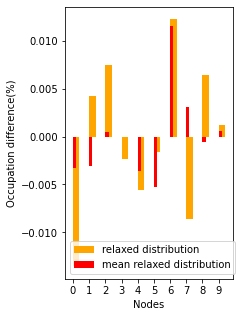

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.3*N, 5))

ax.bar(G.nodes, [h/sum(history[0][-1]) - k for h, k in zip(history[0][-1], pSNorm)], width=0.4, 
       align='edge', color='orange', label='relaxed distribution')
ax.bar(G.nodes, [(h1+h2+h3)/(sum(history[0][-1]) + sum(history[1][-1]) + sum(history[2][-1])) - k 
                 for h1, h2, h3, k in zip(history[0][-1], history[1][-1], history[2][-1], pSNorm)],
       width=0.2, align='edge', color='red', label='mean relaxed distribution')

ax.legend()
ax.set_xlabel("Nodes")
ax.set_ylabel("Occupation difference(%)")
ax.set_xticks(np.arange(0, N, 1))
# ax.grid(True)

plt.show()

In [24]:
nodes = [0, start_node]

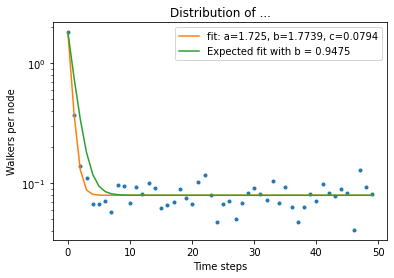

In [30]:
def exp_law(x, a, b, c):
    return a*np.exp(-b*x) + c

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(6,4))

time_evolution = [[h1/total_walkers for h1 in history[0][i]] for i in range(len(history[0]))]
time = np.arange(0, 50)

y = [sum([np.abs(time_evolution[t][n] - pSNorm[n]) for n in G.nodes]) for t in time]

popt, pcov = curve_fit(exp_law, time, y, p0=[1, FiedlerValue, 0]) 

ax.plot(time, y, '.')
ax.plot(time, exp_law(time, *popt), '-',
           label = f"fit: a={round(popt[0],4)}, b={round(popt[1],4)}, c={round(popt[2],4)}")
ax.plot(time, exp_law(time, popt[0], FiedlerValue, popt[2]), '-',
           label = f"Expected fit with b = {round(FiedlerValue, 4)}")

ax.set_title(f"Distribution of ...")
ax.set_xlabel("Time steps")
ax.set_ylabel("Walkers per node")

plt.yscale('log')
ax.legend()

plt.show()

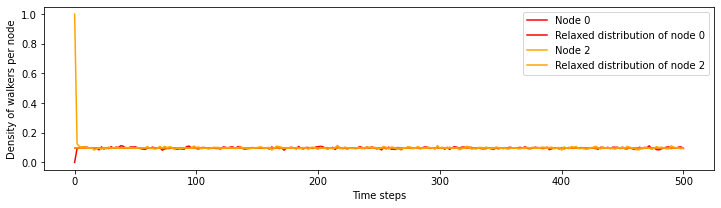

Evolution of 500 time steps for 1000 walkers


In [26]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12,1.5*len(nodes)))
color = ['red', 'orange', 'blue', 'green']

time_evolution = hMean
time = np.arange(0, len(time_evolution), 2)

col = 0
for i in nodes: #list(G.nodes)[0:3]:
    ax.plot(time, [time_evolution[ind][i] for ind in time], label = f"Node {i}", color = color[col])
    ax.plot(time, [pSNorm[i]]*len(time), label = f"Relaxed distribution of node {i}", color = color[col])
    col += 1
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.legend()

plt.show()

print(f"Evolution of {time_steps} time steps for {total_walkers} walkers")